In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#no dado original, havia uma coluna sem nome (com os indexes). seria difícil remover assim. Nomeei-a de "A", para priorizar 
#o index do pandas.

# Função para normalizar todas as colunas de um dataframe pelo método de valor mínimo 0 e máximo 1
def normalizar(df):
    resultado = df.copy()
    for coluna in df.columns:
        if df[coluna].max() == 0:
            continue
        else:
            valor_max = df[coluna].max()
            valor_min = df[coluna].min()
            resultado[coluna] = (df[coluna] - valor_min) / (valor_max - valor_min)
    return resultado


In [2]:
#criando o DataFrame "df_chem"
df = pd.read_csv("Minerals_Database3.csv")  # Importação do dataset para ser utilizado como dataframe
# Remoção de colunas não necessárias para o dataframe

df = df.drop(['A'], axis=1)
df = df.drop(['Name'], axis=1)

dados_cat = df.reindex(df.columns[[0,2,4]], axis = 1) # Remoção de dados categóricos
dados_categoricos = dados_cat.astype("category") # Tratamento de dados para o tipo categórico
newlist = [x for x in range(7,135)] # Range para pegarmos dados que estão em porcentagem
porcent_df = df.reindex(df.columns[newlist], axis = 1) # Coleta dos dados de elementos em porcentagem
df_chem = df.reindex(df.columns[[1,3,5,135,136,137]], axis=1) # Reindexação de um dataframe contendo apenas propriedades fisico-químicas
df_chem
df_chem, dados_categoricos

df_remove=df_chem.loc[(df_chem["Refractive Index"] == 0.000)] #remove as linhas (objetos), cujo valor do índice de refração é 0

df_chem = df_chem.drop(df_remove.index) #considera que o dataframe df_chem é o dataframe com as linhas removidas
print(df_chem)

     Mohs Hardness  Specific Gravity  Refractive Index  Molar Mass  \
0             4.50             3.240             1.580  817.339002   
1             2.75             3.446             1.592  435.069330   
2             2.00             4.420             2.085  921.092220   
4             5.50             1.050             1.634  861.185368   
5             3.50             3.295             1.457  225.618151   
..             ...               ...               ...         ...   
803           7.50             4.650             1.928  526.041800   
805           6.50             3.230             1.702  379.378178   
806           3.50             2.180             1.590  492.887716   
807           7.00             3.411             1.596  263.580584   
808           0.00             3.146             1.633  576.801907   

     Molar Volume  Calculated Density  
0        0.123390               5.498  
1        0.056083               6.439  
2        0.122631               6.234  

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

tamanho = 0.25 # Fração de dados escolhida para treino e teste
seed = 2000

i = df_chem.index
i_treino, i_teste = train_test_split(i, test_size=tamanho, random_state = seed)

df_treino = df_chem.loc[i_treino]
df_teste = df_chem.loc[i_teste]

#print(df_treino)
#print()
#print(df_teste)

In [4]:
# Modelo preditivo de base (baseline)

nome = 'df_chem'
atributos = ["Mohs Hardness","Specific Gravity", 'Molar Mass', 'Molar Volume', 'Calculated Density']
target = ["Refractive Index"]

x_treino = df_treino.reindex(atributos, axis=1).values
y_treino = df_treino.reindex(target, axis=1).values
x_teste = df_teste.reindex(atributos, axis=1).values
y_teste = df_teste.reindex(target, axis=1).values

In [5]:
from sklearn.tree import DecisionTreeRegressor

# cria o modelo
modelo_dt = DecisionTreeRegressor(random_state=1024)

# treina o modelo
modelo_dt.fit(x_treino, y_treino)

# realiza uma previsão usando o modelo treinado
previsao = modelo_dt.predict(x_teste)
#print(previsao)

In [6]:
from sklearn.metrics import mean_squared_error

y_verdadeiro = y_teste
y_previsao = modelo_dt.predict(x_teste)

RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

print(f"O RMSE do modelo árvore de decisão foi de {RMSE}.")

O RMSE do modelo árvore de decisão foi de 0.2859829689044461.


In [7]:
#Hiperparâmetros
from itertools import product

NUM_FOLHAS = 50
NUM_PROFUNDIDADE = 70
#CRITERIO = 'absolute_error'
SPLITTER = "best"
MINIMO_SPLIT = 2
MINIMO_FOLHAS = 1
PESO_FOLHAS = 0.0
MAXIMO_FEATURES = None
IMPUREZA_MINIMO = 0.0
COMPLEXO_ALPHA = 0.0



modelo_dt = DecisionTreeRegressor(
        max_leaf_nodes=NUM_FOLHAS,
        max_depth=NUM_PROFUNDIDADE,
        #criterion=CRITERIO,
        splitter=SPLITTER,
        min_samples_split=MINIMO_SPLIT,
        min_samples_leaf=MINIMO_FOLHAS,
        min_weight_fraction_leaf=PESO_FOLHAS,
        max_features=MAXIMO_FEATURES,
        min_impurity_decrease=IMPUREZA_MINIMO,
        ccp_alpha=COMPLEXO_ALPHA,
        random_state=1024,
    )

modelo_dt.fit(x_treino, y_treino)

y_verdadeiro = y_teste
y_previsao = modelo_dt.predict(x_teste)
RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

print(
    f"A RMSE do modelo de AD usando max_leaf_nodes={NUM_FOLHAS} "
    f"e max_depth={NUM_PROFUNDIDADE} foi um índice refrativo de de {RMSE:.4f}."
    )

A RMSE do modelo de AD usando max_leaf_nodes=50 e max_depth=70 foi um índice refrativo de de 0.2810.


A RMSE do modelo de baseline foi uma Indice Refrativo de 0.2560
A RMSE do modelo de AD usando max_leaf_nodes=50 e max_depth=70 foi um índice refrativo de de 0.2810.

Desse modo, como a RMSE ddo modelo de AD foi maior, o que pode indicar algum tipo de erro ou overfitting.

### Comparação entre hiperparâmetros

In [8]:
#Conjunto 1 de Hiperparâmetros
from itertools import product

NUM_FOLHAS = [None, 30, 60, 100, 150]
NUM_PROFUNDIDADE = [None, 10, 20, 50, 100]
#CRITERIO = 'absolute_error'
#SPLITTER = "best"
MINIMO_SPLIT = [2, 4, 6, 8, 10]
MINIMO_FOLHAS = [1, 2, 4, 6, 8]
#PESO_FOLHAS = 0.0
#MAXIMO_FEATURES = None
#IMPUREZA_MINIMO = 0.0
#COMPLEXO_ALPHA = 0.0




for n_folhas, n_profundidade,min_split,min_folhas in product(NUM_FOLHAS, NUM_PROFUNDIDADE,MINIMO_SPLIT,MINIMO_FOLHAS):
    modelo_dt = DecisionTreeRegressor(
        max_leaf_nodes=n_folhas,
        max_depth=n_profundidade,
        #criterion=criterio,
        #splitter=splitter,
        min_samples_split=min_split,
        min_samples_leaf=min_folhas,
        #min_weight_function_leaf=peso_folhas,
        #max_features=max_features,
        #min_impurity_decrease=impureza,
        #ccp_alpha=alpha,
        random_state=1024,
    )

    modelo_dt.fit(x_treino, y_treino)

    y_verdadeiro = y_teste
    y_previsao = modelo_dt.predict(x_teste)
    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

    print(
    f"O RMSE do modelo AD usando max_leaf_nodes={n_folhas} "
    f",max_depth={n_profundidade}"
    f"min_samples_split={min_split}"
    f"e min_samples_leaf={min_folhas}"
    f"foi de {RMSE:.4f}."
    )

O RMSE do modelo AD usando max_leaf_nodes=None ,max_depth=Nonemin_samples_split=2e min_samples_leaf=1foi de 0.2860.
O RMSE do modelo AD usando max_leaf_nodes=None ,max_depth=Nonemin_samples_split=2e min_samples_leaf=2foi de 0.1918.
O RMSE do modelo AD usando max_leaf_nodes=None ,max_depth=Nonemin_samples_split=2e min_samples_leaf=4foi de 0.1883.
O RMSE do modelo AD usando max_leaf_nodes=None ,max_depth=Nonemin_samples_split=2e min_samples_leaf=6foi de 0.1692.
O RMSE do modelo AD usando max_leaf_nodes=None ,max_depth=Nonemin_samples_split=2e min_samples_leaf=8foi de 0.1492.
O RMSE do modelo AD usando max_leaf_nodes=None ,max_depth=Nonemin_samples_split=4e min_samples_leaf=1foi de 0.2817.
O RMSE do modelo AD usando max_leaf_nodes=None ,max_depth=Nonemin_samples_split=4e min_samples_leaf=2foi de 0.1918.
O RMSE do modelo AD usando max_leaf_nodes=None ,max_depth=Nonemin_samples_split=4e min_samples_leaf=4foi de 0.1883.
O RMSE do modelo AD usando max_leaf_nodes=None ,max_depth=Nonemin_sample

O menor valor de RMSE de Indice Refrativo encontrado foi de "0.0050"
Em comparação, a RMSE do modelo de baseline foi uma Indice Refrativo de "0.1485".
Assim, árvore é um modelo melhor do que o baseline, por apresentar um RMSE significativamente menor.

In [9]:
#Conjunto de Hiperparâmetros 2
from itertools import product

NUM_FOLHAS = [None, 30, 60, 100, 150]
NUM_PROFUNDIDADE = [None, 10, 20, 50, 100]
#CRITERIO = 'absolute_error'
#SPLITTER = "best"
#MINIMO_SPLIT = [2, 4, 6, 8, 10]
#MINIMO_FOLHAS = [1, 2, 4, 6, 8]
#PESO_FOLHAS = 0.0
#MAXIMO_FEATURES = None
#IMPUREZA_MINIMO = 0.0
#COMPLEXO_ALPHA = 0.0




for n_folhas, n_profundidade in product(NUM_FOLHAS, NUM_PROFUNDIDADE):
    modelo_dt = DecisionTreeRegressor(
        max_leaf_nodes=n_folhas,
        max_depth=n_profundidade,
        #criterion=criterio,
        #splitter=splitter,
        #min_samples_split=min_split,
        #min_samples_leaf=min_folhas,
        #min_weight_function_leaf=peso_folhas,
        #max_features=max_features,
        #min_impurity_decrease=impureza,
        #ccp_alpha=alpha,
        random_state=1024,
    )

    modelo_dt.fit(x_treino, y_treino)

    y_verdadeiro = y_teste
    y_previsao = modelo_dt.predict(x_teste)
    RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)

    print(
    f"O RMSE do modelo AD usando max_leaf_nodes={n_folhas} e "
    f"max_depth={n_profundidade}"
    f" foi de {RMSE:.4f}."
    )

O RMSE do modelo AD usando max_leaf_nodes=None e max_depth=None foi de 0.2860.
O RMSE do modelo AD usando max_leaf_nodes=None e max_depth=10 foi de 0.2848.
O RMSE do modelo AD usando max_leaf_nodes=None e max_depth=20 foi de 0.2870.
O RMSE do modelo AD usando max_leaf_nodes=None e max_depth=50 foi de 0.2860.
O RMSE do modelo AD usando max_leaf_nodes=None e max_depth=100 foi de 0.2860.
O RMSE do modelo AD usando max_leaf_nodes=30 e max_depth=None foi de 0.2704.
O RMSE do modelo AD usando max_leaf_nodes=30 e max_depth=10 foi de 0.2704.
O RMSE do modelo AD usando max_leaf_nodes=30 e max_depth=20 foi de 0.2704.
O RMSE do modelo AD usando max_leaf_nodes=30 e max_depth=50 foi de 0.2704.
O RMSE do modelo AD usando max_leaf_nodes=30 e max_depth=100 foi de 0.2704.
O RMSE do modelo AD usando max_leaf_nodes=60 e max_depth=None foi de 0.2849.
O RMSE do modelo AD usando max_leaf_nodes=60 e max_depth=10 foi de 0.2849.
O RMSE do modelo AD usando max_leaf_nodes=60 e max_depth=20 foi de 0.2849.
O RMSE 

Com os hiperparâmetros definidos, o menor RMSE foi "0.2849".
Ainda sim não foi melhor que a baseline de RMSE = "0.2810".



In [10]:
#Relação folhas com RMSE
lista_RMSE = []
folhas = range(2,150)
for i in folhas:
    modelo_dt = DecisionTreeRegressor(max_leaf_nodes=i,random_state=1024)
    modelo_dt.fit(x_treino, y_treino)
    y_verdadeiro = y_teste
    y_previsao = modelo_dt.predict(x_teste)
    RMSE_valores = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
    lista_RMSE.append(RMSE_valores)
    print(lista_RMSE)

[0.15267944508266162]
[0.15267944508266162, 0.1521770330972088]
[0.15267944508266162, 0.1521770330972088, 0.14817778586007097]
[0.15267944508266162, 0.1521770330972088, 0.14817778586007097, 0.1401127635576794]
[0.15267944508266162, 0.1521770330972088, 0.14817778586007097, 0.1401127635576794, 0.14786742362894129]
[0.15267944508266162, 0.1521770330972088, 0.14817778586007097, 0.1401127635576794, 0.14786742362894129, 0.14786742362894129]
[0.15267944508266162, 0.1521770330972088, 0.14817778586007097, 0.1401127635576794, 0.14786742362894129, 0.14786742362894129, 0.14507627039030435]
[0.15267944508266162, 0.1521770330972088, 0.14817778586007097, 0.1401127635576794, 0.14786742362894129, 0.14786742362894129, 0.14507627039030435, 0.14205341225229287]
[0.15267944508266162, 0.1521770330972088, 0.14817778586007097, 0.1401127635576794, 0.14786742362894129, 0.14786742362894129, 0.14507627039030435, 0.14205341225229287, 0.20977590650624886]
[0.15267944508266162, 0.1521770330972088, 0.1481777858600709

[Text(0.5, 0, 'Folhas'), Text(0, 0.5, 'RMSE')]

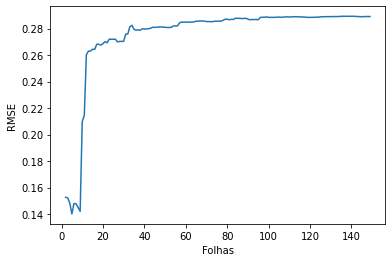

In [11]:
relacao_folha_RMSE = sns.lineplot(x = folhas, y = lista_RMSE)
relacao_folha_RMSE.set(xlabel = "Folhas", ylabel = "RMSE")

In [12]:
#Relação de profundidade com RMSE 
lista_RMSE = []
profundidade = range(1,100)
for i in profundidade:
    modelo_dt = DecisionTreeRegressor(max_depth=i,random_state=1024)
    modelo_dt.fit(x_treino, y_treino)
    y_verdadeiro = y_teste
    y_previsao = modelo_dt.predict(x_teste)
    RMSE_valores = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
    lista_RMSE.append(RMSE_valores)
    print(lista_RMSE)

[0.15267944508266162]
[0.15267944508266162, 0.1443356494136016]
[0.15267944508266162, 0.1443356494136016, 0.1370145465817278]
[0.15267944508266162, 0.1443356494136016, 0.1370145465817278, 0.15379953794671924]
[0.15267944508266162, 0.1443356494136016, 0.1370145465817278, 0.15379953794671924, 0.263711313436781]
[0.15267944508266162, 0.1443356494136016, 0.1370145465817278, 0.15379953794671924, 0.263711313436781, 0.28334145531785815]
[0.15267944508266162, 0.1443356494136016, 0.1370145465817278, 0.15379953794671924, 0.263711313436781, 0.28334145531785815, 0.28477621152775495]
[0.15267944508266162, 0.1443356494136016, 0.1370145465817278, 0.15379953794671924, 0.263711313436781, 0.28334145531785815, 0.28477621152775495, 0.2797582780097361]
[0.15267944508266162, 0.1443356494136016, 0.1370145465817278, 0.15379953794671924, 0.263711313436781, 0.28334145531785815, 0.28477621152775495, 0.2797582780097361, 0.2844918343350744]
[0.15267944508266162, 0.1443356494136016, 0.1370145465817278, 0.1537995379

[Text(0.5, 0, 'Profundidade'), Text(0, 0.5, 'RMSE')]

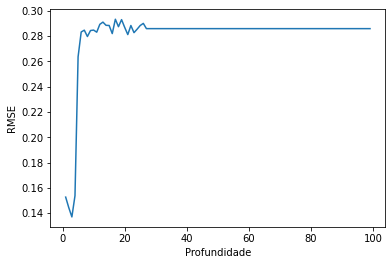

In [13]:
relacao_profundidade_RMSE = sns.lineplot(x = profundidade, y = lista_RMSE)
relacao_profundidade_RMSE.set(xlabel = "Profundidade", ylabel = "RMSE")

In [14]:
#Relação samples split com RMSE
lista_RMSE = []
samples_split = range(2,100)
for i in samples_split:
    modelo_dt = DecisionTreeRegressor(min_samples_split=i,random_state=1024)
    modelo_dt.fit(x_treino, y_treino)
    y_verdadeiro = y_teste
    y_previsao = modelo_dt.predict(x_teste)
    RMSE_valores = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
    lista_RMSE.append(RMSE_valores)
    print(lista_RMSE)

[0.2859829689044461]
[0.2859829689044461, 0.2816998058434633]
[0.2859829689044461, 0.2816998058434633, 0.28170638498156236]
[0.2859829689044461, 0.2816998058434633, 0.28170638498156236, 0.28010104351237175]
[0.2859829689044461, 0.2816998058434633, 0.28170638498156236, 0.28010104351237175, 0.2783019405524661]
[0.2859829689044461, 0.2816998058434633, 0.28170638498156236, 0.28010104351237175, 0.2783019405524661, 0.2792626055677357]
[0.2859829689044461, 0.2816998058434633, 0.28170638498156236, 0.28010104351237175, 0.2783019405524661, 0.2792626055677357, 0.2726975930424494]
[0.2859829689044461, 0.2816998058434633, 0.28170638498156236, 0.28010104351237175, 0.2783019405524661, 0.2792626055677357, 0.2726975930424494, 0.2731904789676844]
[0.2859829689044461, 0.2816998058434633, 0.28170638498156236, 0.28010104351237175, 0.2783019405524661, 0.2792626055677357, 0.2726975930424494, 0.2731904789676844, 0.22887527870364216]
[0.2859829689044461, 0.2816998058434633, 0.28170638498156236, 0.2801010435123

[Text(0.5, 0, 'S_Split'), Text(0, 0.5, 'RMSE')]

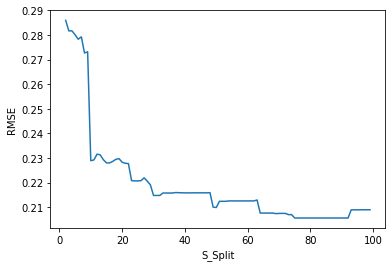

In [15]:
relacao_split_sample_RMSE = sns.lineplot(x = samples_split, y = lista_RMSE)
relacao_split_sample_RMSE.set(xlabel = "S_Split", ylabel = "RMSE")

In [16]:
#Relação de folhas com RMSE
lista_RMSE = []
minimo_folhas = range(1,100)
for i in minimo_folhas:
    modelo_dt = DecisionTreeRegressor(min_samples_leaf=i,random_state=1024)
    modelo_dt.fit(x_treino, y_treino)
    y_verdadeiro = y_teste
    y_previsao = modelo_dt.predict(x_teste)
    RMSE_valores = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
    lista_RMSE.append(RMSE_valores)
    print(lista_RMSE)

[0.2859829689044461]
[0.2859829689044461, 0.1918057269370898]
[0.2859829689044461, 0.1918057269370898, 0.18260486219506566]
[0.2859829689044461, 0.1918057269370898, 0.18260486219506566, 0.1882980090433073]
[0.2859829689044461, 0.1918057269370898, 0.18260486219506566, 0.1882980090433073, 0.17365958101491447]
[0.2859829689044461, 0.1918057269370898, 0.18260486219506566, 0.1882980090433073, 0.17365958101491447, 0.16915719723246922]
[0.2859829689044461, 0.1918057269370898, 0.18260486219506566, 0.1882980090433073, 0.17365958101491447, 0.16915719723246922, 0.1585955666766478]
[0.2859829689044461, 0.1918057269370898, 0.18260486219506566, 0.1882980090433073, 0.17365958101491447, 0.16915719723246922, 0.1585955666766478, 0.1492279215930073]
[0.2859829689044461, 0.1918057269370898, 0.18260486219506566, 0.1882980090433073, 0.17365958101491447, 0.16915719723246922, 0.1585955666766478, 0.1492279215930073, 0.15294321853408496]
[0.2859829689044461, 0.1918057269370898, 0.18260486219506566, 0.1882980090

[Text(0.5, 0, 'S_Split'), Text(0, 0.5, 'RMSE')]

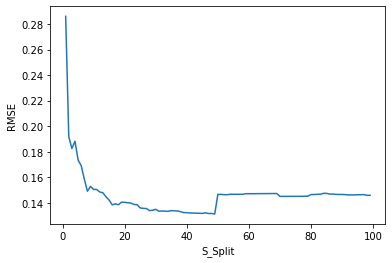

In [17]:
relacao_minimo_folha_RMSE = sns.lineplot(x = minimo_folhas, y = lista_RMSE)
relacao_minimo_folha_RMSE.set(xlabel = "S_Split", ylabel = "RMSE")

Aparentemente, baseado principalmente no comportamento das folhas e profundidade há um sobreajuste.

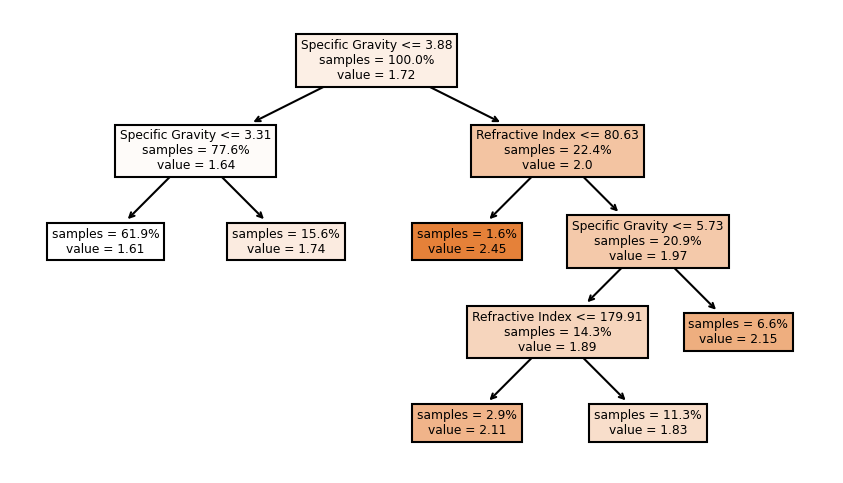

In [18]:
from matplotlib import pyplot as plt
from sklearn import tree

# cria e treina o modelo
modelo_dt = DecisionTreeRegressor(
    max_leaf_nodes=6,
    random_state=1024,
)
modelo_dt.fit(x_treino, y_treino)

# cria os objetos de figura e eixo
fig, axe = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(7, 4),
    dpi=150,
)

# plota o grafo da árvore de decisão
tree.plot_tree(
    modelo_dt,
    feature_names=["Mohs Hardness","Specific Gravity", "Refractive Index", "Dispersion", 'Molar Mass', 'Molar Volume', 'Calculated Density'],
    ax=axe,
    impurity=False,
    filled=True,
    proportion=True,
    precision=2,
)

# mostra o plot para o usuário
plt.show()